# Automatic Salt Interpretation on 3D Seismic using Amazon Sagemaker

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Define SEGY read function](#Define-SEGY-read-function)
  3. [Read SEGY data from S3](#Read-SEGY-data-from-S3)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Prediction](#Prediction)
6. [Write clustering results to SEGY format and upload to S3 ](#Write-clustering-results-to-SEGY-format-and-upload-to-S3 )

## Introduction

This notebook demonstrates a classification problem, specifically of seismic attributes. In areas where only seismic data is available with not enogh well data, there is no ground truth to do a supervised learning. A method of consideration for such cases can be "clustering", and in particular, the method that we'll look at today is called k-means clustering. In this method, each point belongs to the cluster with the closest mean, and the data is partitioned into a number of clusters that is specified when framing the problem. The idea here is to use clustering to highlight features of interest such as geo anomalies (salt, fault, channels, etc), or areas that might have certain rock/ fluid properties (high porosity, high hydrocanbon saturation etc).  

We will select a number of seismic attributes that are stored as SEGY files on s3, resize, and use them in the clustering algorithm. These are the seismic attributes available on s3:

    - Cosine phase
    - First derivative
    - Instantaneous Frequency
    - RMS Amplitude
    - Semblance
    - Original seismic data

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

<IPython.core.display.Javascript object>


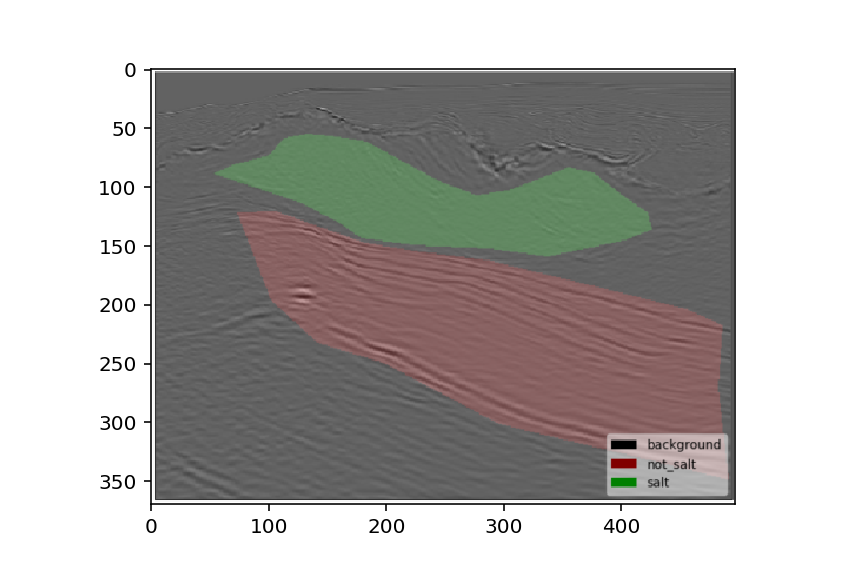

<IPython.core.display.Javascript object>


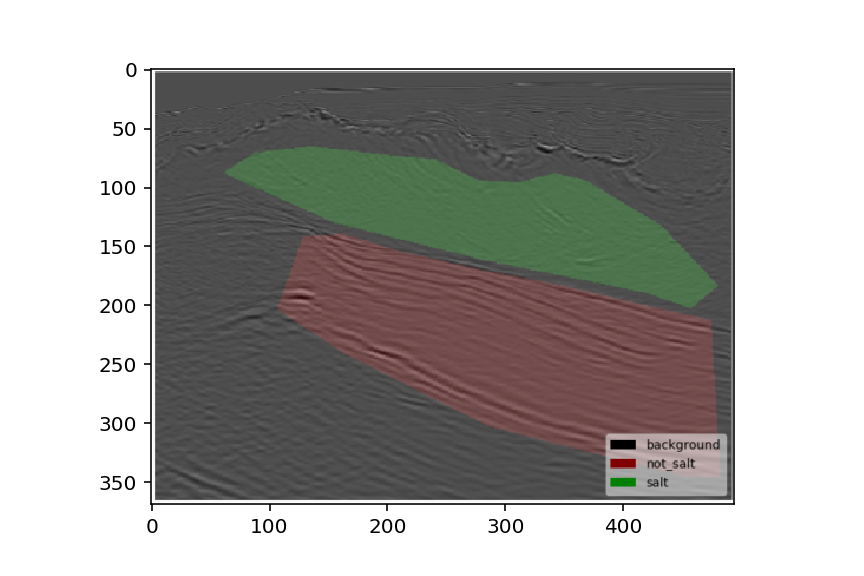

In [229]:
import matplotlib.image as mpimg

plt.figure()
#     plt.clf()
plt.imshow(mpimg.imread('label_viz1.png'))
#    plt.colorbar()
# plt.title(str())

plt.figure()
plt.figsize=(10, 10)
#     plt.clf()
plt.imshow(mpimg.imread('label_viz2.png'))

In [2]:
from sagemaker import get_execution_role

role = get_execution_role()

### Define SEGY read function

Here we will define a function using segyio package to read 3D SEGY files. segyio package can be installed using simple pip installation (currently commented below).

In [3]:
!pip install segyio

import segyio
import numpy as np
import matplotlib.pyplot as plt
spec = segyio.spec()

def segy_decomp(segy_file, plot_data = False, read_direc='xline', inp_res = np.float32):
    # segy_file: filename of the segy-cube to be imported
    # plot_data: boolean that determines if a random xline should be plotted to test the reading
    # read_direc: which way the SEGY-cube should be read; 'xline', or 'inline'
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)

    # Make an empty object to hold the output data
    print('Starting SEG-Y decompressor')
    output = segyio.spec()

    # open the segyfile and start decomposing it
    with segyio.open(segy_file, "r" ) as segyfile:
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()

        # Store some initial object attributes
        output.inl_start = segyfile.ilines[0]
        output.inl_end = segyfile.ilines[-1]
        output.inl_step = segyfile.ilines[1] - segyfile.ilines[0]

        output.xl_start = segyfile.xlines[0]
        output.xl_end = segyfile.xlines[-1]
#        print('output.inl_step========',output.inl_step)
        if output.xl_end==0:
            output.xl_step = 1
        else:   output.xl_step = segyfile.xlines[1] - segyfile.xlines[0]
                
        output.t_start = int(segyfile.samples[0])
        output.t_end = int(segyfile.samples[-1])
        output.t_step = int(segyfile.samples[1] - segyfile.samples[0])


        # Pre-allocate a numpy array that holds the SEGY-cube
        output.data = np.empty((segyfile.xline.len,segyfile.iline.len,\
                        (output.t_end - output.t_start)//output.t_step+1), dtype = np.float32)

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for il_index in range(segyfile.xline.len):
                output.data[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'xline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for xl_index in range(segyfile.iline.len):
                output.data[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'full':
            ## NOTE: 'full' for some reason invokes float32 data
            # Potentially time this to find the "fast" direction
            #start = time.time()
            output.data = segyio.tools.cube(segy_file)
            #end = time.time()
            #print(end - start)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # If sepcified, plot a given x-line to test the read data
        if plot_data:
            # Take a given xline
            data = output.data[:,0,:]
            # Plot the read x-line
            plt.imshow(data.T,interpolation="nearest", cmap="gray")
            plt.colorbar()
            plt.show()


    # Return the output object
    print('Finished using the SEG-Y decompressor')
    return output


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Read SEGY data from S3

We will read the first 3 seismic files from S3 into a python array (one at a time), cut them into smaller cubes, reshape them into a 1D array, and save them to a variable called "att". After saving, we remove each segy volume from disk before moving to the next volume.  


['seismic-classification/label_classification/CGV_3CRNRS_LabelSalt_InstFeq.segy',
 'seismic-classification/label_classification/CGV_3CRNRS_LabelSalt_RMS.segy',
 'seismic-classification/label_classification/CGV_3CRNRS_LabelSalt_original.segy',
 'seismic-classification/label_classification/CGV_3CRNRS_LabelSalt_semblance.segy']

4

['CGV_3CRNRS_LabelSalt_InstFeq.segy',
 'CGV_3CRNRS_LabelSalt_RMS.segy',
 'CGV_3CRNRS_LabelSalt_original.segy',
 'CGV_3CRNRS_LabelSalt_semblance.segy']

Starting SEG-Y decompressor


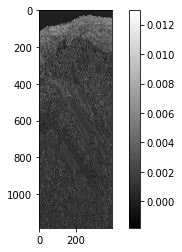

Finished using the SEG-Y decompressor


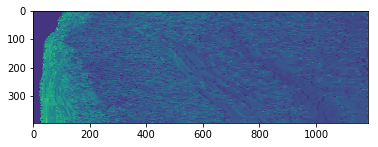

dslice shape (468864,)



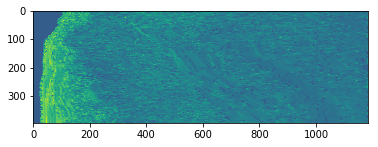

dslice shape (468864,)



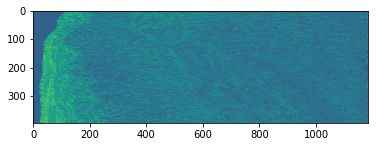

dslice shape (468864,)

Starting SEG-Y decompressor


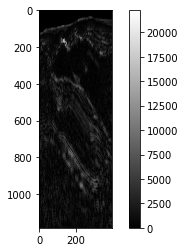

Finished using the SEG-Y decompressor


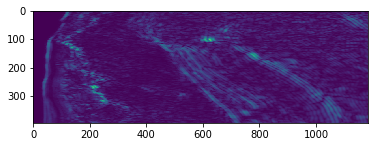

dslice shape (468864,)



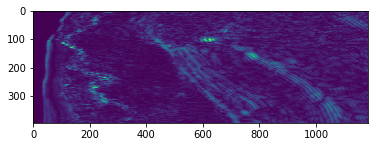

dslice shape (468864,)



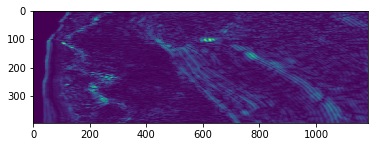

dslice shape (468864,)

Starting SEG-Y decompressor


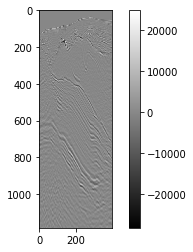

Finished using the SEG-Y decompressor


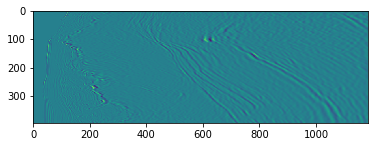

dslice shape (468864,)



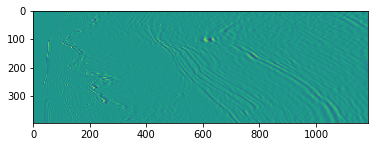

dslice shape (468864,)



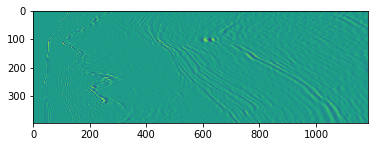

dslice shape (468864,)

Starting SEG-Y decompressor


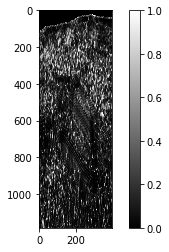

Finished using the SEG-Y decompressor


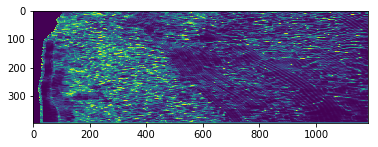

dslice shape (468864,)



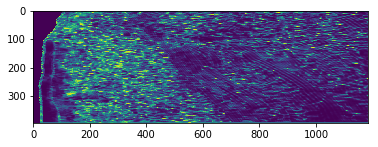

dslice shape (468864,)



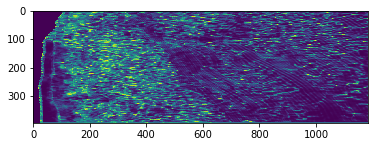

dslice shape (468864,)



In [232]:
import boto3
import os
import glob
%matplotlib inline


BUCKET_NAME = 'ns-workbench'  # bucket name where data is stored
s3 = boto3.resource('s3')


bucket_list = []
for key in s3.Bucket(BUCKET_NAME).objects.all():
    bucket_list.append(key.key)
    
samp_sgy = [s for s in bucket_list if '.segy' in s and '.xml' not in s]
display(samp_sgy)

display(len(samp_sgy))
FILE_NAME = [s.split("/")[-1] for s in samp_sgy]
# FILE_NAME = FILE_NAME[-3:]  # keep only the last 3 attributes: Freq, Semblance, and RMSAMp
display(FILE_NAME)


PREFIX = 'seismic-classification/label_classification'                            # Location of the file within the S3 bucket
# (396, 441, 1184)

new_il_start = 20   # starting number for inlines for the new seismic cube
new_xl_start = 350   # starting number for xlines for the new seismic cube
new_ts_start = 1  # starting number for vertical samples for the new seismic cube

new_il_end = 390    # end number for inlines for the new seismic cube
new_xl_end = 450    # end number for xlines for the new seismic cube
new_ts_end = 1000    # end number for vertical samples for the new seismic cube

#num_att = len(sgy_names)-3  # Number of attributes to be used for the clustering
#num_att = len(FILE_NAME)-3  # Number of attributes to be used for the clustering
num_att = len(FILE_NAME)  # Number of attributes to be used for the clustering

inlines = [385, 390, 393]
# att = np.zeros(((new_il_end - new_il_start)*(new_xl_end - new_xl_start)*(new_ts_end - new_ts_start),num_att))
data_sei = np.zeros(((new_il_end - new_il_start)*(new_xl_end - new_xl_start)*(new_ts_end - new_ts_start),num_att))
datacuts = []

samples = 396
traces= 1184
ln = samples*traces
num_lbl_files = 3

att_and_label = np.zeros((num_lbl_files*samples*traces,num_att))

for i in range(num_att):
    url = '{}/{}'.format(PREFIX, FILE_NAME[i]) 
    s3.Bucket(BUCKET_NAME).download_file(url, FILE_NAME[i])
    segy_obj = segy_decomp(segy_file = FILE_NAME[i],
               plot_data = True,
               read_direc = 'xline',
               inp_res = np.float32 ) 
    
    data_sei = segy_obj.data
    for idx,j in enumerate(inlines):
        dslice = data_sei[:,j,:]
        plt.imshow(dslice)
        plt.show()
        dslice = dslice.T.reshape(ln)
        print('dslice shape',dslice.shape)
        print()
        att_and_label[(idx)*ln:(idx+1)*ln, i] = dslice        
#     data_sei = data_sei[:,new_xl_start:new_xl_end,:]
    data_sei = data_sei[new_il_start:new_il_end,new_xl_start:new_xl_end,new_ts_start:new_ts_end]
    datacuts.append(data_sei)
    for i in glob.glob("*.segy"):
        os.remove(i) 

# att=np.float32(att)        

In [5]:
import pandas as pd
# len(idx*ln:(idx+1)*ln-1)
print(idx*ln)
print((idx+1)*ln-1)
print(att_and_label.shape)
print(data_sei.shape)
data = pd.DataFrame(att_and_label, columns = ['InstFeq','RMS','Seis','Semb'])   
display(data.head())

# sem = data['Semb'].values[:ln].reshape(samples,traces)
# plt.imshow(sem.T, interpolation = 'nearest', cmap = 'gray')
# plt.show()

937728
1406591
(1406592, 4)
(370, 40, 884)


InstFeq  RMS  Seis  Semb
0      0.0  0.0   0.0   0.0
1      0.0  0.0   0.0   0.0
2      0.0  0.0   0.0   0.0
3      0.0  0.0   0.0   0.0
4      0.0  0.0   0.0   0.0

0    float64
1    float64
2    float64
dtype: object

(468864, 3)


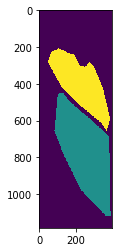

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


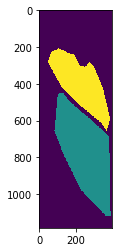

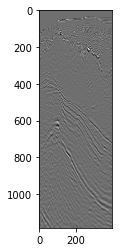

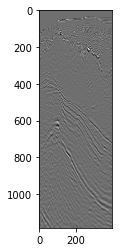

In [12]:
import pandas as pd
labels = pd.read_csv('all_labels.csv', header = None)

display(labels.dtypes)
labels = labels.values
print(labels.shape)

# samples = 396
# traces= 1184
label1 = labels[:,0]
label2 = label1.reshape(1184,396)
plt.imshow(label2)
plt.show()
labels = labels.T.reshape(labels.shape[0]*labels.shape[1])


data['labels'] = labels

lb1 = data['labels'][:1184*396]
sei1 = data['Seis'][:1184*396] 

lb2 = lb1.reshape(1184,396)
sei2 = sei1.reshape(1184,396)

plt.imshow(lb2)
plt.show()

plt.imshow(sei2,cmap = 'gray')
plt.show()


plt.imshow(att_and_label[:ln,2].reshape(1184,396),cmap = 'gray')
plt.show()

data.to_csv('salt_data.csv', index = False)

In [85]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='ns-workbench' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/xgboost-byo-salt'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 140 ms


In [21]:
# Remove non-numeric columns
import pandas as pd
data = pd.read_csv('salt_data.csv')
data['labels'] = np.round(data['labels'].values+1.)
data['labels'] = data['labels'].astype(int)
data2 = data[:6]
# Remove rows with missing values
data.dropna(inplace=True)
data = data[data['labels']>1]

# Write file back to disk
data.to_csv('salt_data_new.csv', index=False)

In [22]:
%%time

import io
import boto3
import random

# def data_split(FILE_DATA, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST, TARGET_VAR):

FILE_DATA = 'salt_data_new.csv'
TARGET_VAR = 'labels'
FILE_TRAIN = 'salt_train.csv'
FILE_VALIDATION = 'salt_validation.csv'
FILE_TEST = 'salt_test.csv'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
    
data = pd.read_csv(FILE_DATA)
n = data.shape[0]
# Make the first column the target feature    
cols = data.columns.tolist()
target_pos = data.columns.get_loc(TARGET_VAR)
cols.pop(target_pos)
cols = [TARGET_VAR] + cols
data = data.loc[:,cols]

data[TARGET_VAR] =  data[TARGET_VAR].astype('category')          

num_of_data = len(data)
num_train = int((PERCENT_TRAIN/100.0)*n)
num_valid = int((PERCENT_VALIDATION/100.0)*n)
num_test = int((PERCENT_TEST/100.0)*n)

# Shuffle the data
data = data.sample(frac=1, replace=False)

# Split data
train_data = data.iloc[:num_train,:]
test_data = data.iloc[(num_train+1):(num_train+1+num_test),:]
valid_data = data.iloc[(num_train+1+num_test+1):n,:]

test_y = test_data[TARGET_VAR].values
test_X = test_data.drop([TARGET_VAR], axis=1).values

val_X = valid_data.drop([TARGET_VAR], axis=1).values
val_y = valid_data[TARGET_VAR].values

train_y = train_data[TARGET_VAR].values
train_X = train_data.drop([TARGET_VAR], axis=1).values

CPU times: user 524 ms, sys: 12 ms, total: 536 ms
Wall time: 537 ms


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


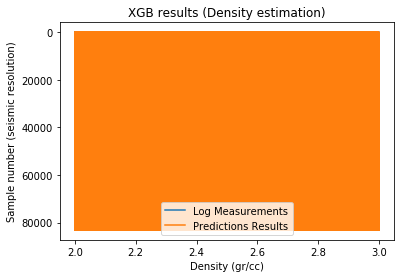

Accuracy is =  83.20 %


In [23]:
import os
import boto3
import re
from sagemaker import get_execution_role
import xgboost as xgb
import sklearn as sk 
from sklearn.pipeline import make_pipeline, make_union
from xgboost.sklearn import  XGBClassifier
from numpy  import array
import matplotlib.pyplot as plt
import numpy as np

bt = xgb.XGBClassifier(colsample_bytree=0.9, learning_rate=0.12,
                       gamma=0.8, max_depth=3, num_class=2, min_child_weight=10, n_estimators=150, subsample=0.85, seed = 17,
                       objective='multi:softmax')   # Setup xgboost model

bt.fit(train_X, train_y, # Train it to our data
       eval_set=[(val_X, val_y)], 
       verbose=False)

predictions = bt.predict(test_X)

predictions = array(predictions)
predictions = np.float64(predictions)
test_y = np.float64(test_y)

accuracy = len(np.where(predictions == test_y)[0])/len(predictions)
print('Accuracy is = ',"%.2f"% (accuracy*100), '%')

dslice shape (369630,)
dslice shape (369630,)
dslice shape (369630,)
dslice shape (369630,)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<IPython.core.display.Javascript object>


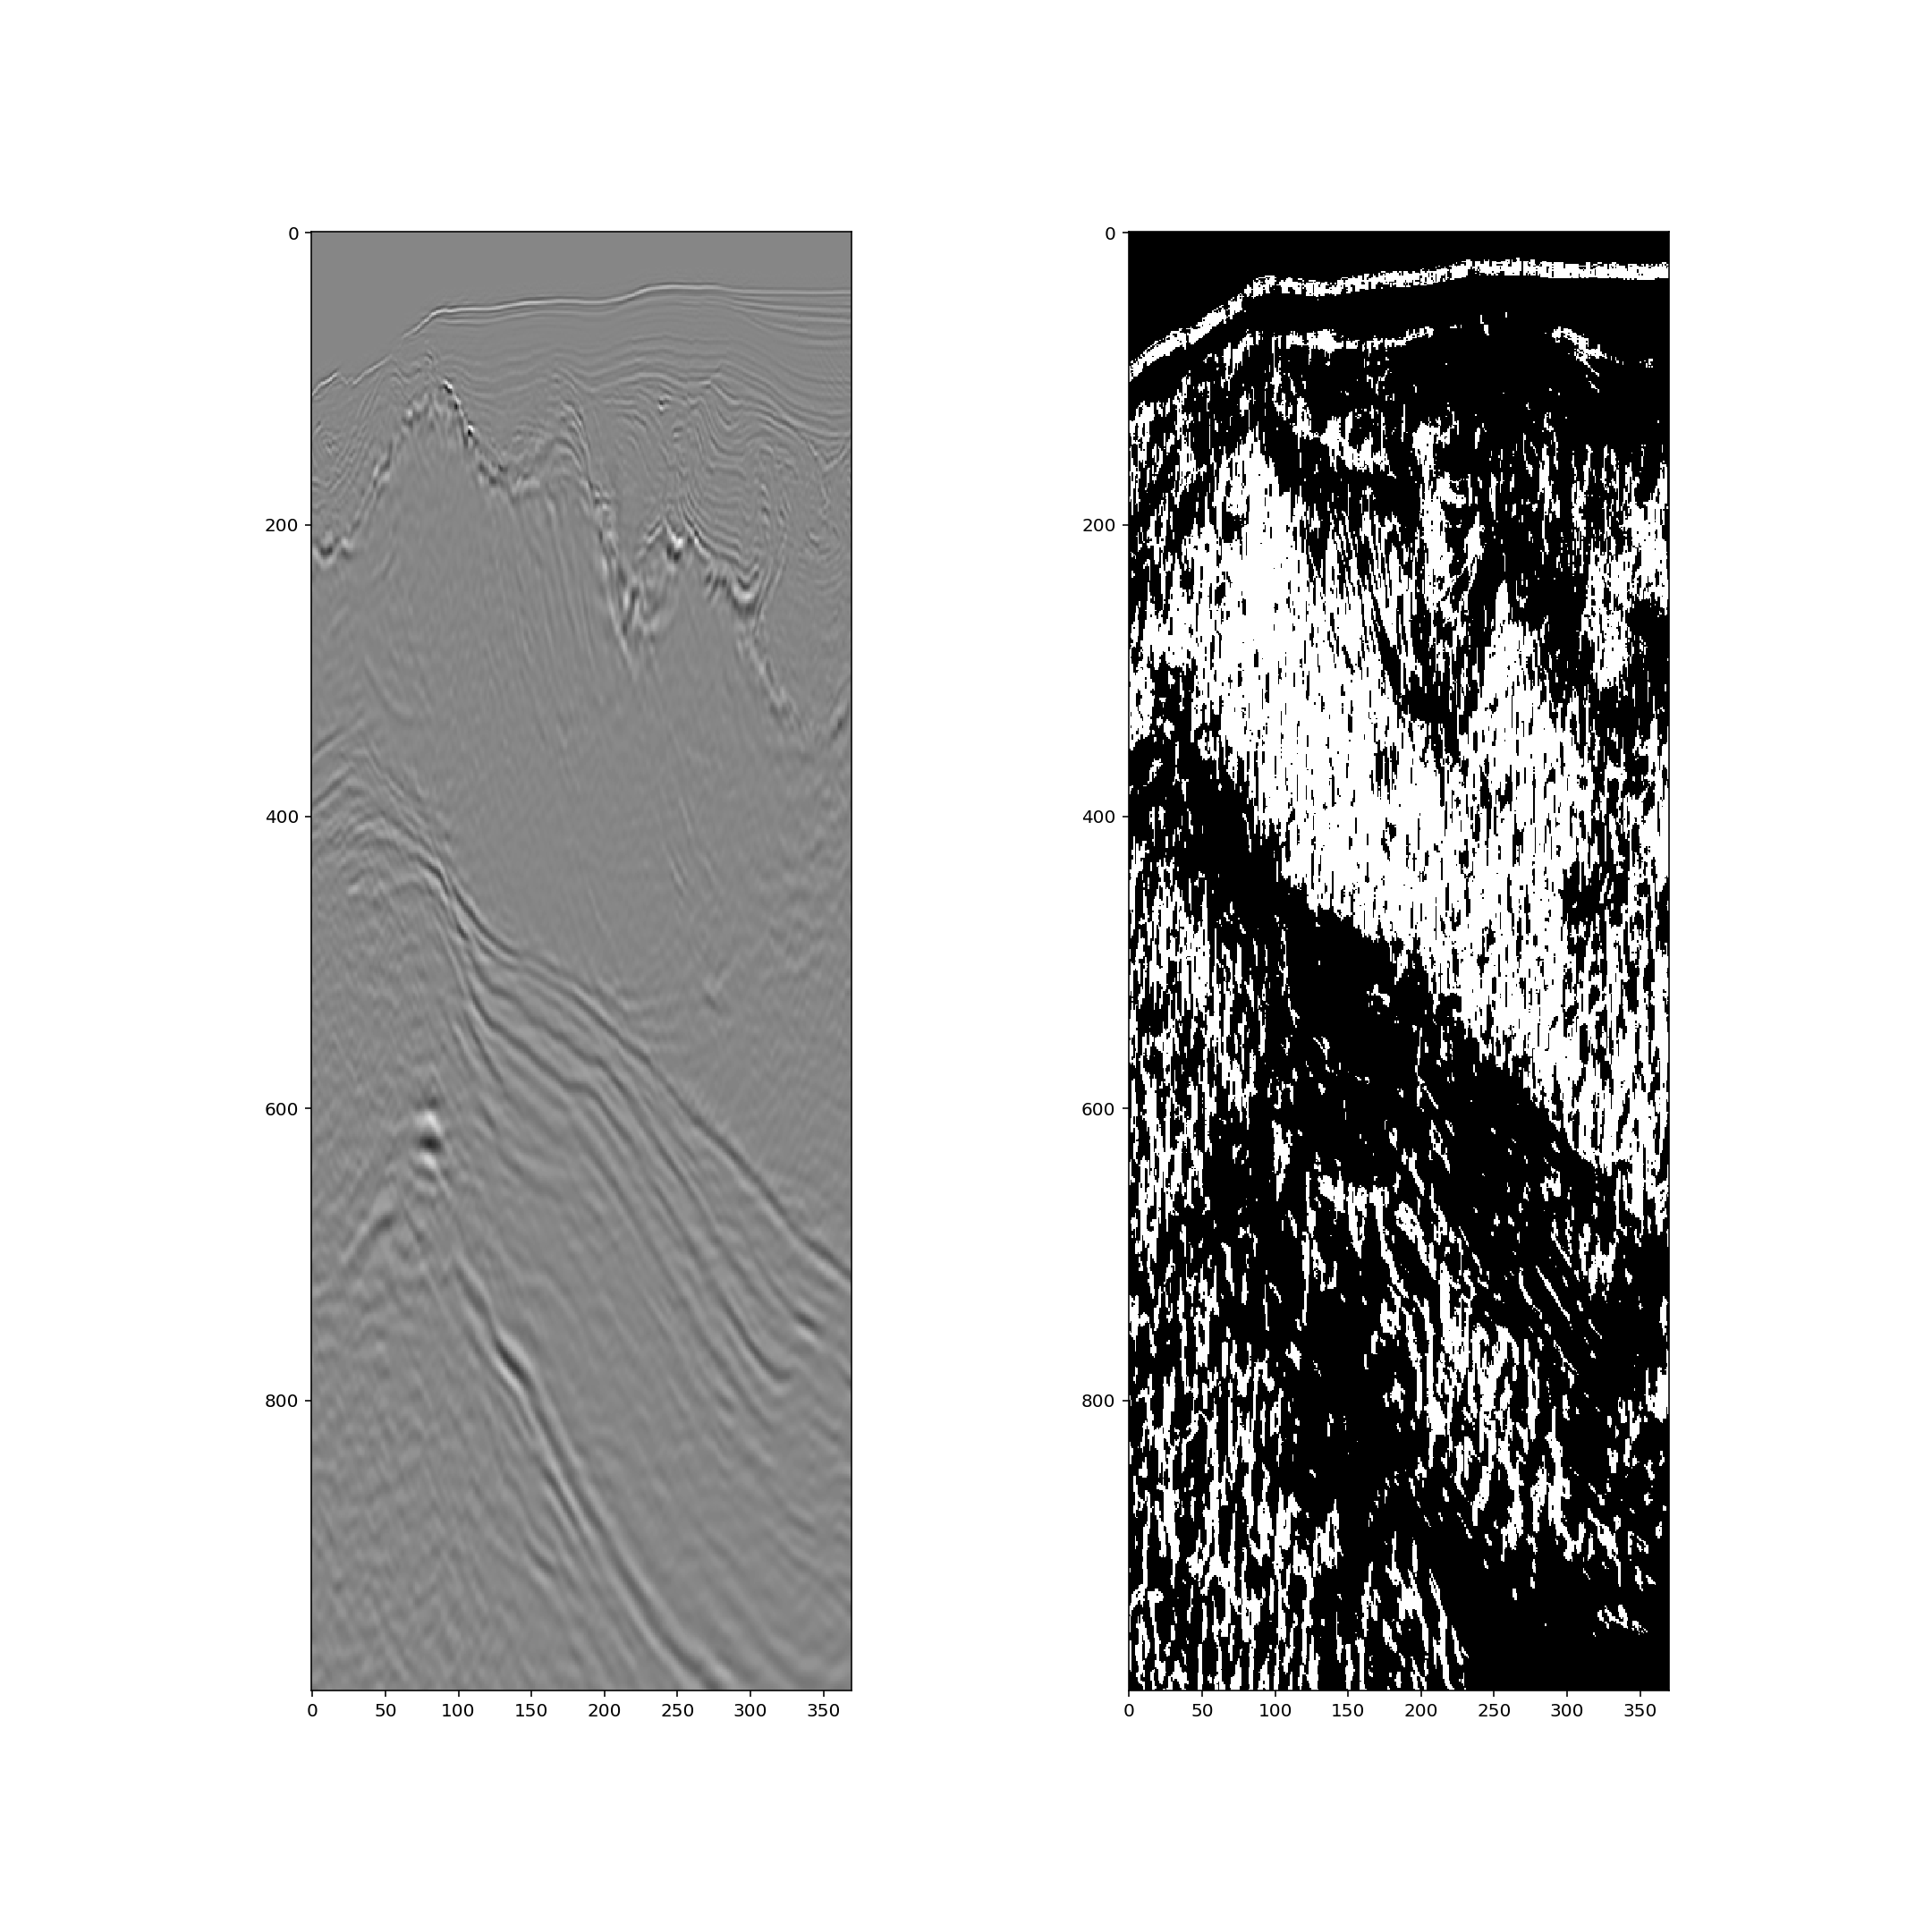

In [226]:
test_att = np.zeros((datacuts[1][:,30,:].shape[0]*datacuts[1][:,30,:].shape[1],num_att))

inline_num = 39

for i in range(num_att):
    dslice = datacuts[i][:,inline_num,:]
    dslice = dslice.reshape(dslice.shape[0]*dslice.shape[1])
    print('dslice shape',dslice.shape)
    test_att[:, i] = dslice  

    
predictions = bt.predict(test_att)
from numpy  import array
import numpy as np
dslice = datacuts[i][:,inline_num,:]

predictions = array(predictions)
predictions = np.float64(predictions)
pred_reshape = predictions.reshape(dslice.shape[0],dslice.shape[1])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)
seis = ax1.imshow(datacuts[2][:,10,:].T, cmap='gray', interpolation='nearest')
salt = ax2.imshow(pred_reshape.T, cmap='gray', interpolation='nearest')
plt.savefig('TPOT_log.tif')


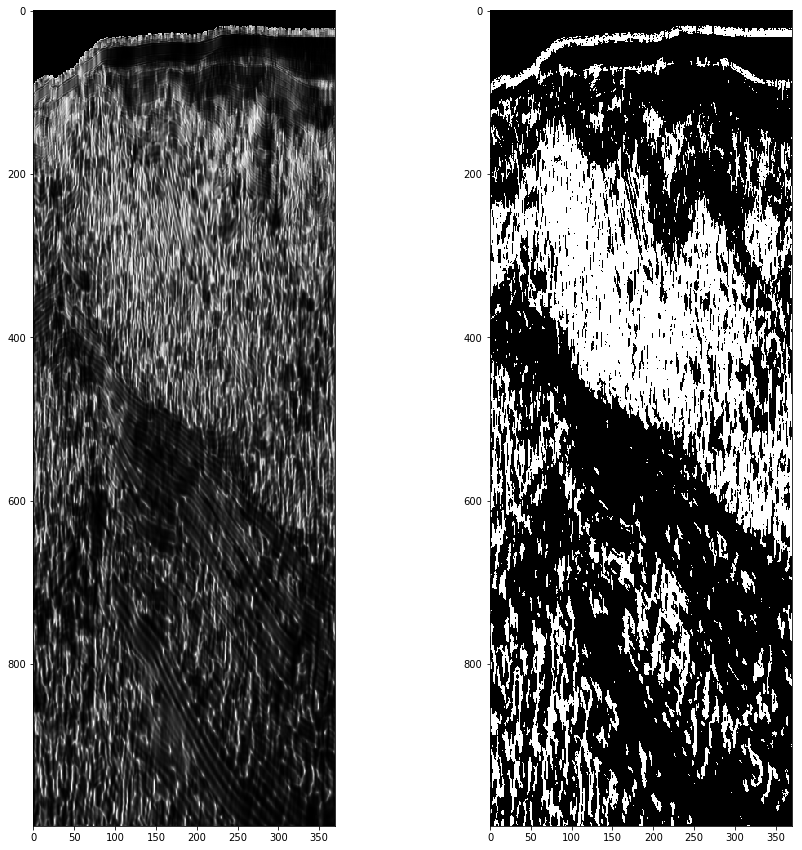

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)
seis = ax1.imshow(datacuts[3][:,10,:].T, cmap='gray', interpolation='nearest')
salt = ax2.imshow(pred_reshape.T, cmap='gray', interpolation='nearest')
plt.savefig('salt_interp.tif')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


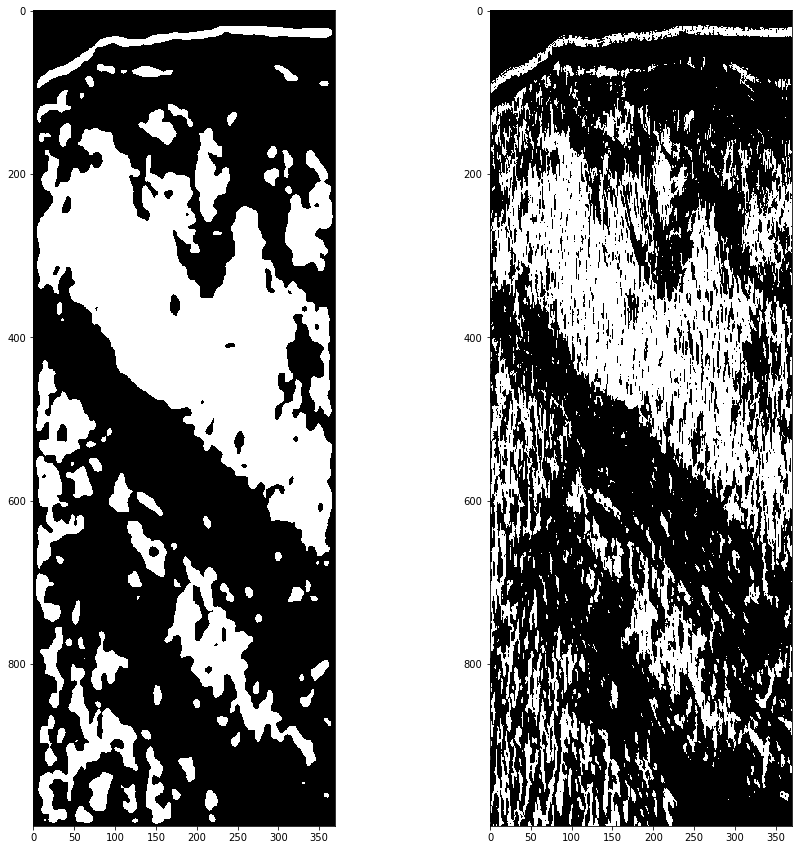

In [76]:
import scipy as sp
import scipy.ndimage

sigma_y = 4.0
sigma_x = 3.0
sigma = [sigma_y, sigma_x]
y = sp.ndimage.filters.gaussian_filter(pred_reshape, sigma, mode='constant')

thresh = 2.4
y[y > thresh] = 3.
y[y <= thresh] = 1.


fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)
seis = ax1.imshow(y.T, cmap='gray', interpolation='nearest')
salt = ax2.imshow(pred_reshape.T, cmap='gray', interpolation='nearest')
print(y[:100,:100])
# plt.savefig('salt_interp.tif')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


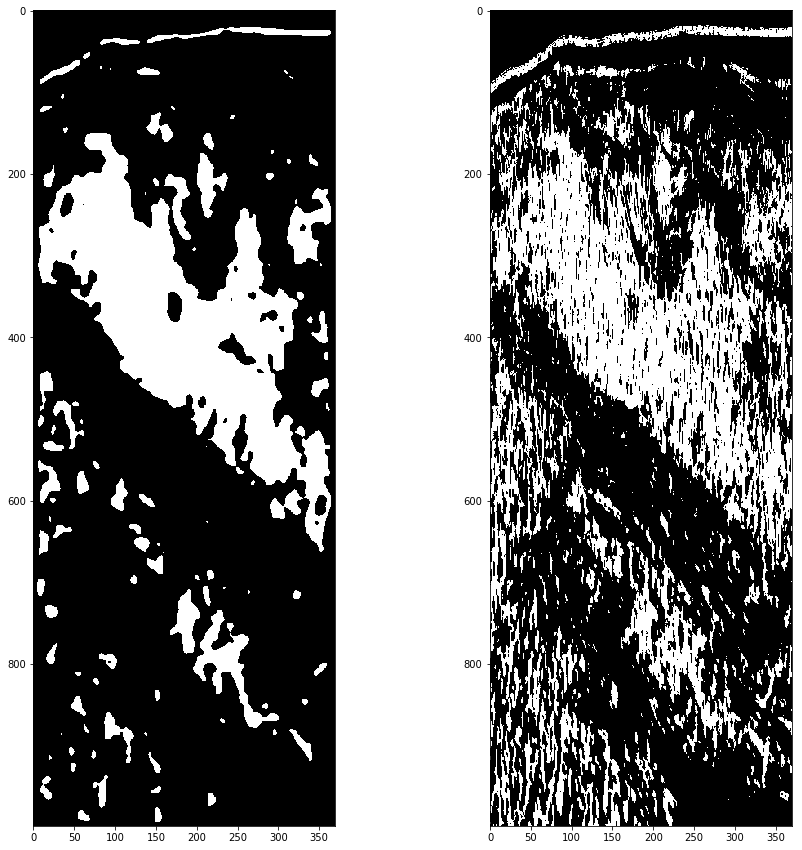

In [77]:
import scipy as sp
import scipy.ndimage

sigma_y = 4.0
sigma_x = 3.0
sigma = [sigma_y, sigma_x]
y = sp.ndimage.filters.gaussian_filter(pred_reshape, sigma, mode='constant')

thresh = 2.6
y[y > thresh] = 3.
y[y <= thresh] = 1.

fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)
seis = ax1.imshow(y.T, cmap='gray', interpolation='nearest')
salt = ax2.imshow(pred_reshape.T, cmap='gray', interpolation='nearest')


In [238]:
all_data = np.zeros((datacuts[1].shape[0]*datacuts[1].shape[1]*datacuts[1].shape[2],num_att))

for i in range(num_att):
    dslice = datacuts[i]
    dslice = dslice.reshape(dslice.shape[0]*dslice.shape[1]*dslice.shape[2])
    all_data[:, i] = dslice  

In [239]:
np.savetxt('test_att.csv',test_att, delimiter = ',')
np.savetxt('all_salt_data.csv',all_data, delimiter = ',')

### Save the trained model file
Note that the model file name must satisfy the regular expression pattern: `^[a-zA-Z0-9](-*[a-zA-Z0-9])*;`. The model file also need to tar-zipped. 

In [89]:
model_file_name = "salt-prediction-xgboost"
bt._Booster.save_model(model_file_name)
!tar czvf model.tar.gz $model_file_name

salt-prediction-xgboost


## Upload the pre-trained model to S3

In [91]:
fObj = open("model.tar.gz", 'rb')
key= os.path.join(prefix, model_file_name, 'model.tar.gz')
boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fObj)

## Set up hosting for the model

### Import model into hosting
This involves creating a SageMaker model from the model file previously uploaded to S3.

In [92]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
container = containers[boto3.Session().region_name]

In [93]:
%%time
from time import gmtime, strftime

model_name = model_file_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 'https://s3-{}.amazonaws.com/{}/{}'.format(region,bucket,key)
sm_client = boto3.client('sagemaker')

print (model_url)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_url,
}

create_model_response2 = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response2['ModelArn'])

https://s3-us-east-1.amazonaws.com/ns-workbench/sagemaker/xgboost-byo-salt/salt-prediction-xgboost/model.tar.gz
arn:aws:sagemaker:us-east-1:401213972244:model/salt-prediction-xgboost2018-04-15-18-27-59
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 333 ms


### Create endpoint configuration

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, you can create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [94]:
from time import gmtime, strftime

endpoint_config_name = 'XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

XGBoostEndpointConfig-2018-04-15-18-28-04
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:401213972244:endpoint-config/xgboostendpointconfig-2018-04-15-18-28-04


### Create endpoint
Lastly, you create the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [95]:
%%time
import time

endpoint_name = 'XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

XGBoostEndpoint-2018-04-15-18-28-13
arn:aws:sagemaker:us-east-1:401213972244:endpoint/xgboostendpoint-2018-04-15-18-28-13
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:401213972244:endpoint/xgboostendpoint-2018-04-15-18-28-13
Status: InService
CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 7min 1s


## Validate the model for use
Now you can obtain the endpoint from the client library using the result from previous operations and generate classifications from the model using that endpoint.

In [96]:
runtime_client = boto3.client('runtime.sagemaker')

In [295]:

import json

np.savetxt("test_point.csv", test_att[50000:50010], delimiter=",")
file_name = 'test_point.csv' #customize to your test file, will be 'mnist.single.test' if use data above

with open(file_name, 'r') as f:
    payload = f.read().strip()
    
# payload = [line for line in payload.split('\n')]

# payload = '\n'.join(test_data)

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
# result = response['Body'].read().decode('ascii')
# result = response['Body'].read().decode('utf-8')
print(response['Body'].read())

b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0'


In [293]:

result1 = np.array(result.split(','))
print((result1))
print((response['Body']))

['0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0']


In [290]:
print(len(result))

10


In [240]:
########################################################################
######################### Batch Predict  ########################
########################################################################

import json

file_name = "all_salt_data.csv" #customize to your test file, will be 'mnist.single.test' if use data above

import sys        
def batch_pred_salt(data, batch_size):
    items = len(data)
    for offset in range(0, items, batch_size):
            print(offset)
            if offset+batch_size < items:
                payload = '\n'.join(data[offset:(offset+batch_size)])
                response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                                   ContentType='text/csv', 
                                                   Body=payload)
                result = response['Body'].read().decode('utf-8')
                result= result.split(',')
                result = array(result)
                result = np.float64(result)
                arrs.extend(result)

            else:
                payload = '\n'.join(data[offset:items])
                response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                                   ContentType='text/csv', 
                                                   Body=payload)
                result = response['Body'].read().decode('utf-8')
                result= result.split(',')
                result = array(result)
                result = np.float64(result)
                arrs.extend(result)



            sys.stdout.write('.')
    return arrs
                
with open(file_name, 'r') as f:
    payload = f.read().strip()

arrs = []

test_data = [line for line in payload.split('\n')]
predict_all = batch_pred_salt(test_data, 40000)


0
.40000
.80000
.120000
.160000
.200000
.240000
.280000
.320000
.360000
.400000
.440000
.480000
.520000
.560000
.600000
.640000
.680000
.720000
.760000
.800000
.840000
.880000
.920000
.960000
.1000000
.1040000
.1080000
.1120000
.1160000
.1200000
.1240000
.1280000
.1320000
.1360000
.1400000
.1440000
.1480000
.1520000
.1560000
.1600000
.1640000
.1680000
.1720000
.1760000
.1800000
.1840000
.1880000
.1920000
.1960000
.2000000
.2040000
.2080000
.2120000
.2160000
.2200000
.2240000
.2280000
.2320000
.2360000
.2400000
.2440000
.2480000
.2520000
.2560000
.2600000
.2640000
.2680000
.2720000
.2760000
.2800000
.2840000
.2880000
.2920000
.2960000
.3000000
.3040000
.3080000
.3120000
.3160000
.3200000
.3240000
.3280000
.3320000
.3360000
.3400000
.3440000
.3480000
.3520000
.3560000
.3600000
.3640000
.3680000
.3720000
.3760000
.3800000
.3840000
.3880000
.3920000
.3960000
.4000000
.4040000
.4080000
.4120000
.4160000
.4200000
.4240000
.4280000
.4320000
.4360000
.4400000
.4440000
.4480000
.4520000
.456000

In [253]:
clusters1=np.array(predict_all)
clusters1 = clusters1.reshape(datacuts[1][:,:,:].shape[0],datacuts[1][:,:,:].shape[1],datacuts[1][:,:,:].shape[2])


In [254]:
sigma_y = 3.0
sigma_x = 2.0
sigma = [sigma_y, sigma_x]

for i in range(0,clusters1.shape[1]):
    clusters1[:,i,:] = sp.ndimage.filters.gaussian_filter(clusters1[:,i,:], sigma, mode='constant')

thresh = .6

clusters1[clusters1 > thresh] = 3.
clusters1[clusters1 <= thresh] = 1.

<IPython.core.display.Javascript object>


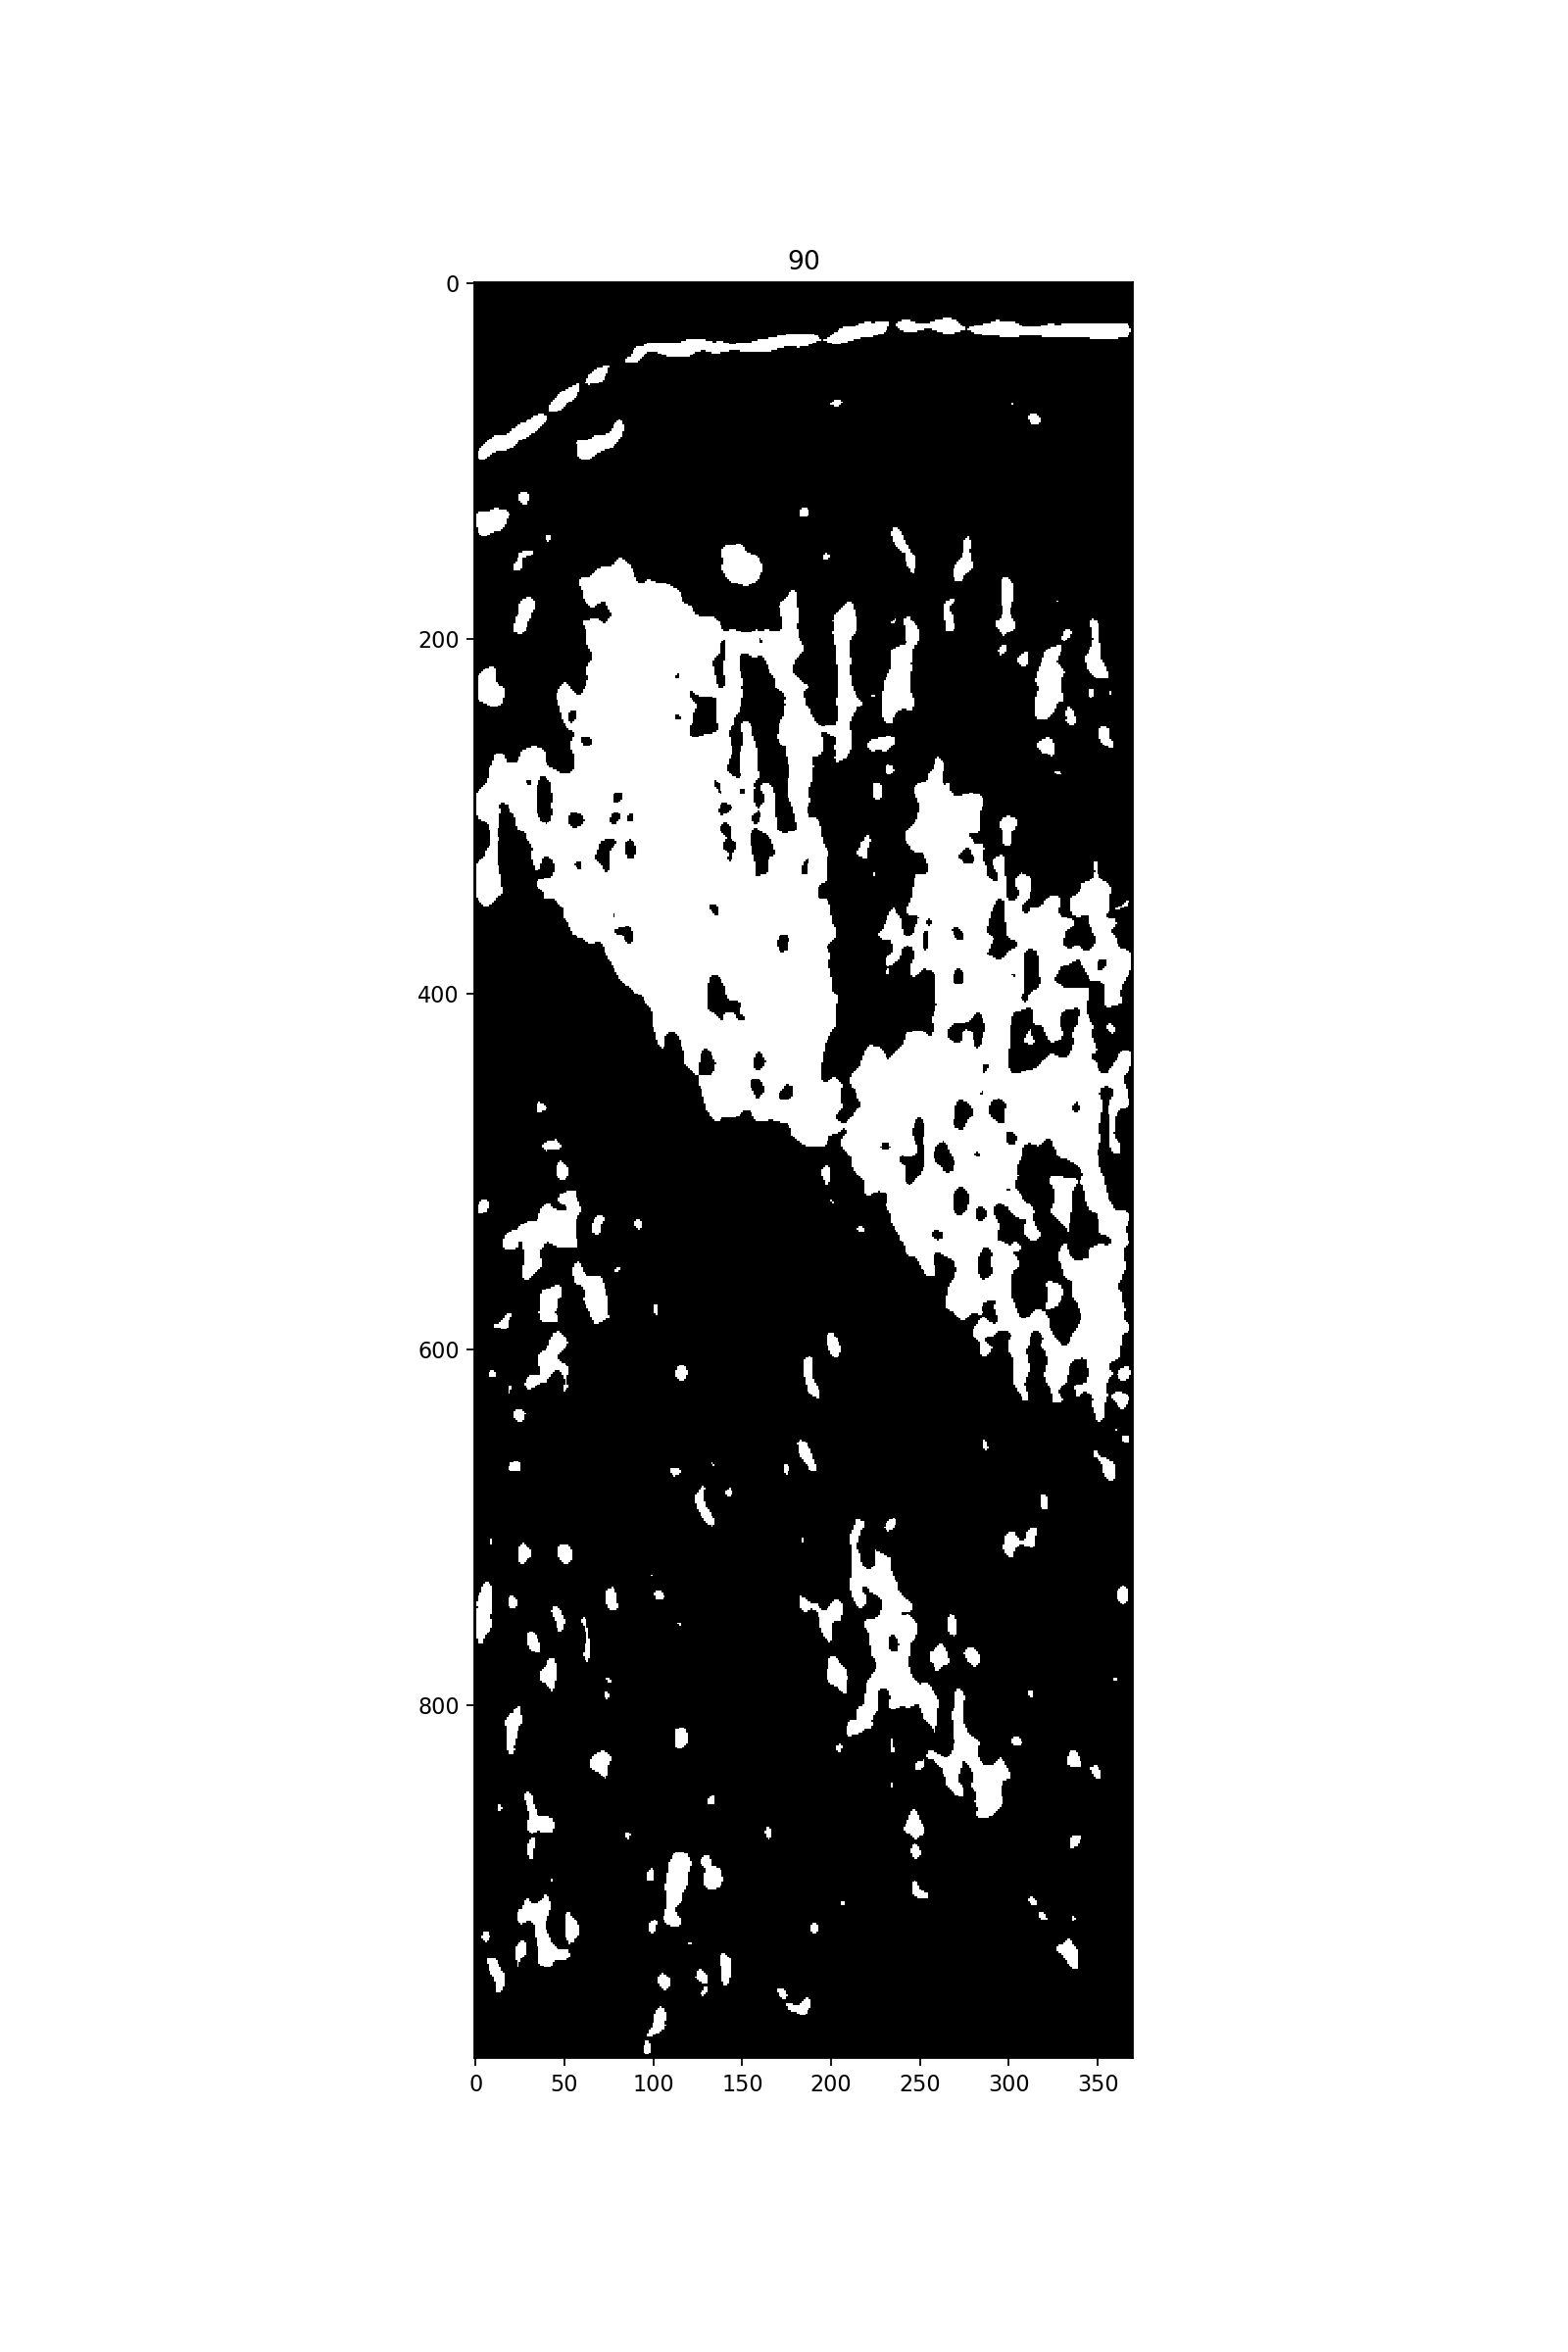

In [296]:
#########################################################
####### Animate All INLINE/ XLINE/ TIME SLICE   ########
#########################################################
%matplotlib notebook

fig = plt.figure(figsize=(10,15), dpi=80)
ax = fig.add_subplot(111)
plt.ion() 
fig.show()
fig.canvas.draw()
step = 1
for i in range(0,clusters1.shape[1],step):
    ax.clear()
    ax.imshow(clusters1[:,i,:].T, cmap="gray")  #  Showing timesclices with "step" increments
    plt.title(str(i))
    fig.canvas.draw()

<IPython.core.display.Javascript object>


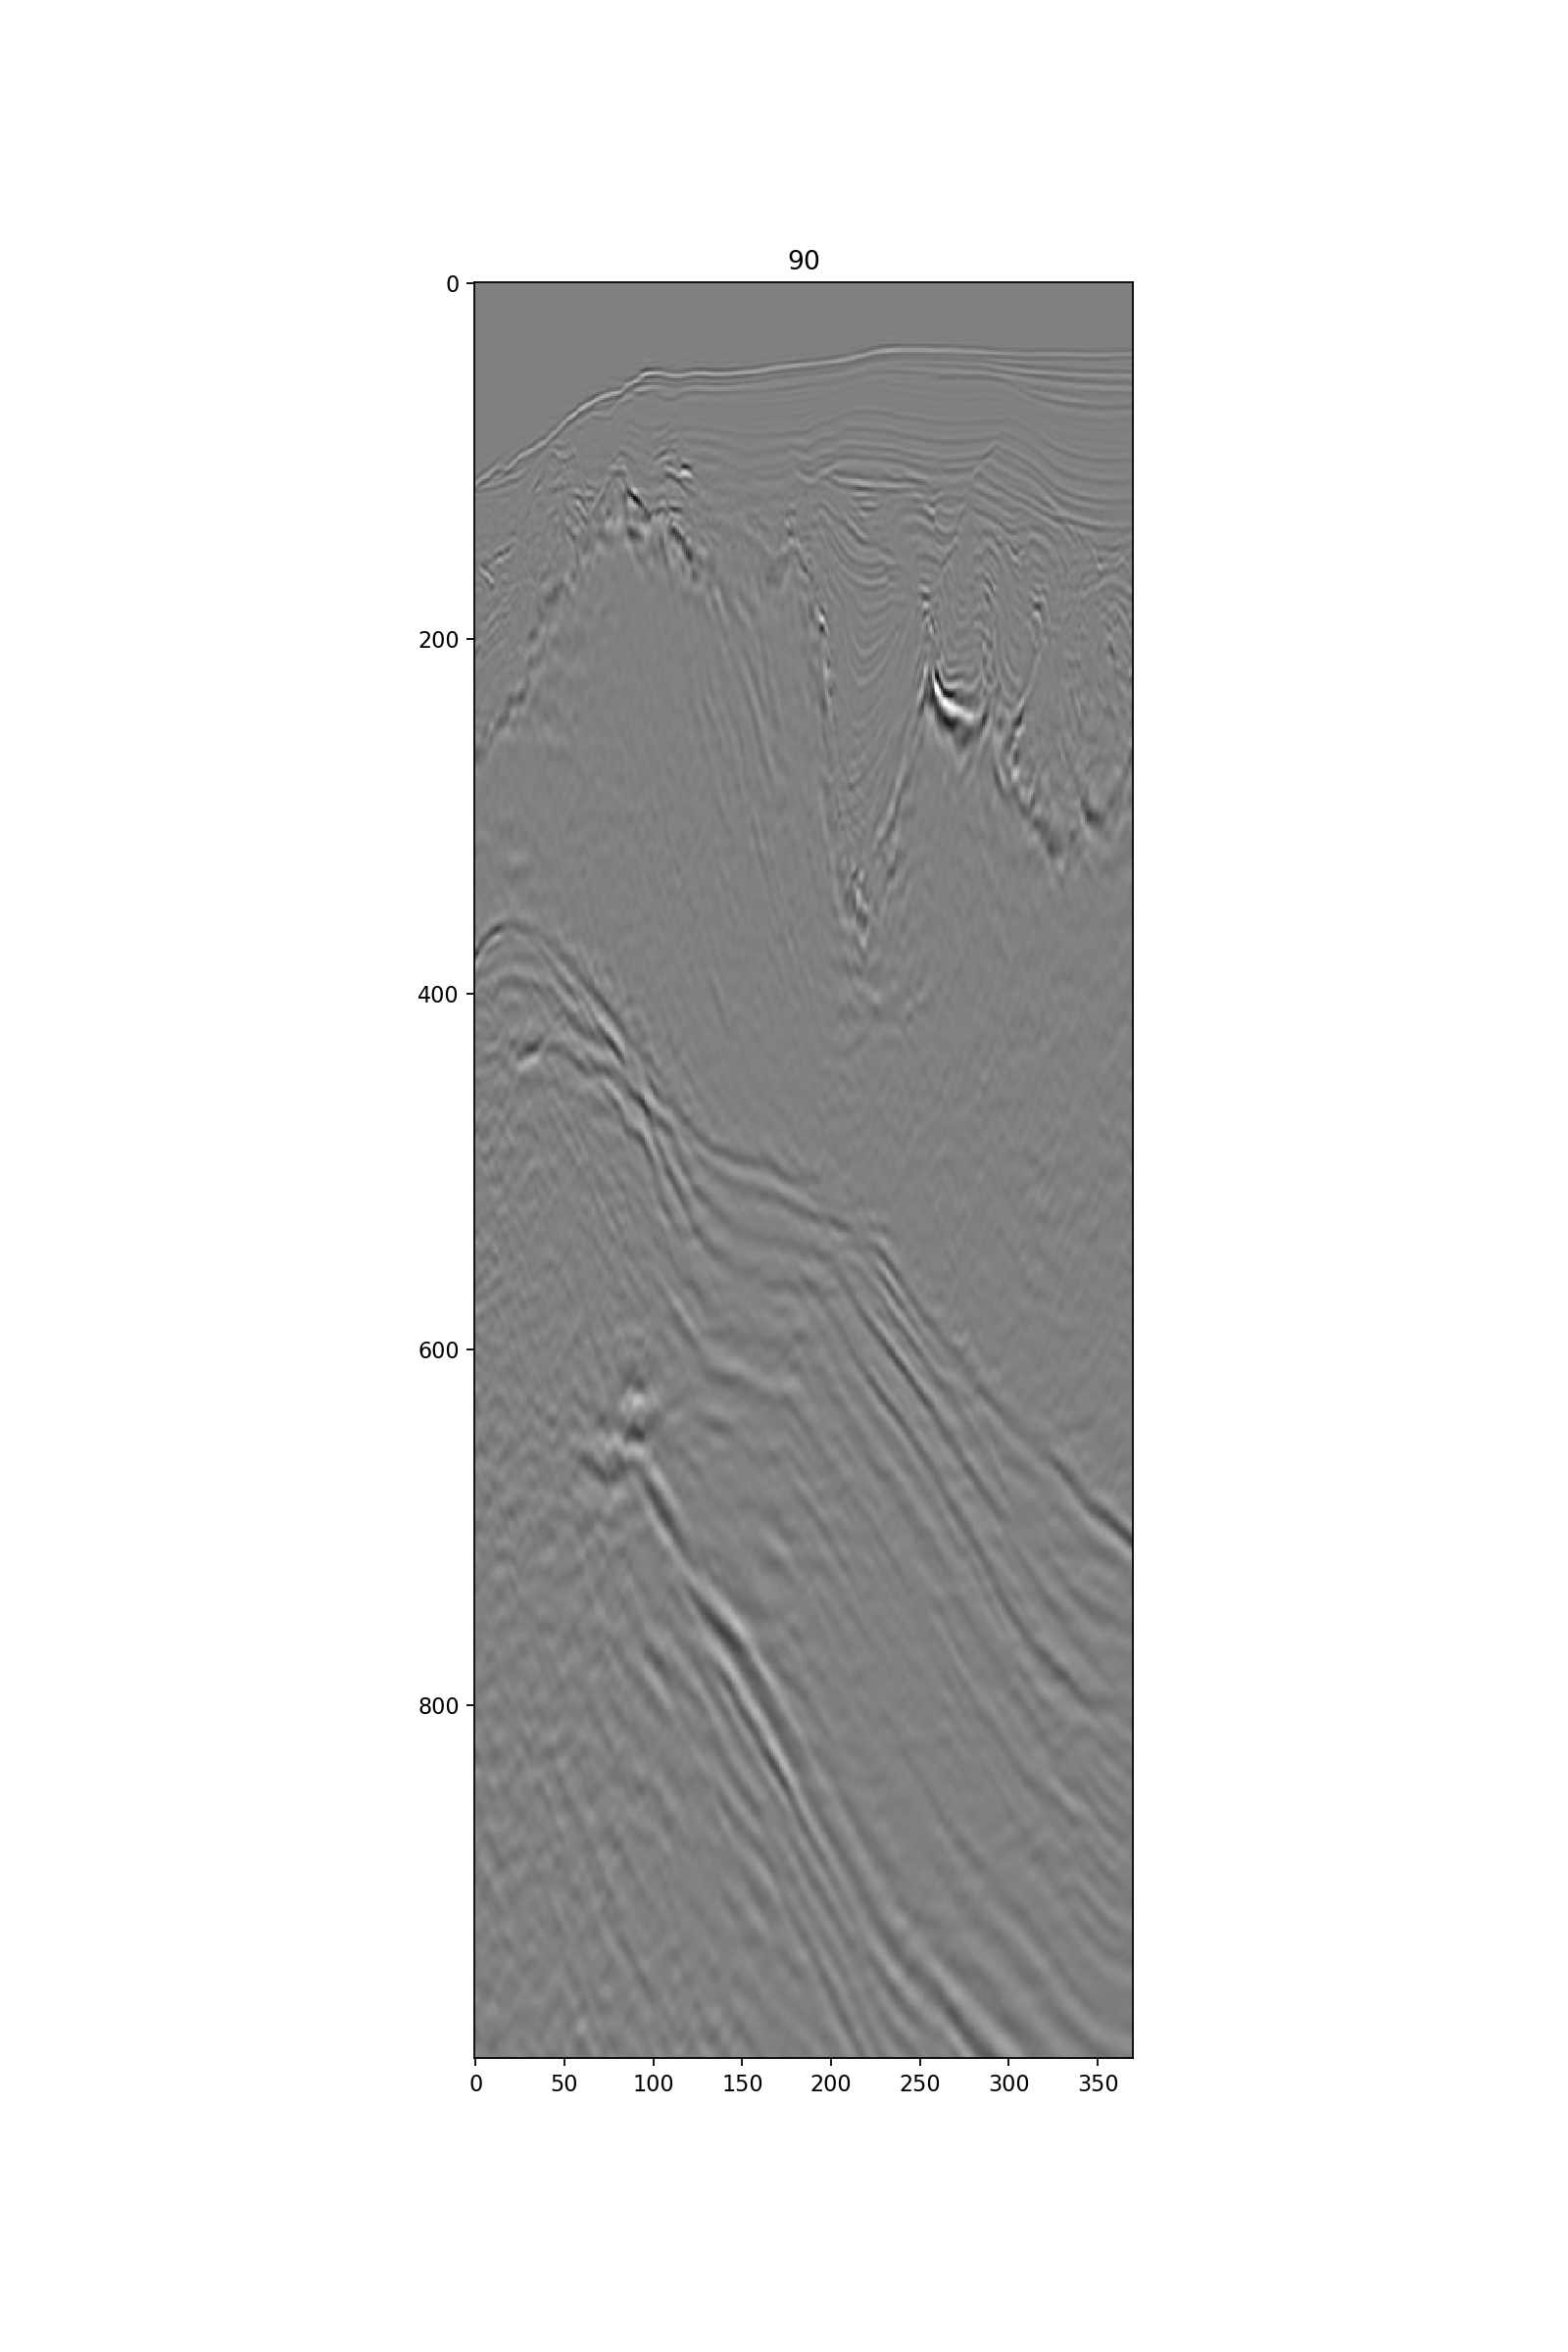

In [258]:
#########################################################
####### Animate All INLINE/ XLINE/ TIME SLICE   ########
#########################################################
%matplotlib notebook

fig = plt.figure(figsize=(10,15), dpi=80)
ax = fig.add_subplot(111)
plt.ion() 
fig.show()
fig.canvas.draw()
step = 1
for i in range(0,clusters1.shape[1],step):
    ax.clear()
    ax.imshow(datacuts[2][:,i,:].T, cmap="gray")  #  Showing timesclices with "step" increments
    plt.title(str(i))
    fig.canvas.draw()

## Write clustering results to SEGY format and upload to S3 
After running the clustering algorithm on the entire dataset, we will can write it as a segy file, and upload it into S3 bucket. 

In [224]:
spec = segyio.spec()
spec.sorting = 2
spec.format  = 1
clusters1=np.single(clusters1)

spec.ilines = list(range(clusters1.shape[0]))
spec.xlines = list(range(clusters1.shape[1]))
spec.samples = list(range(clusters1.shape[2]))
fsgy='salt_interp.sgy'

with segyio.create(fsgy , spec) as f:

    # write the line itself to the file and the inline number in all this line's headers
    for ilno in spec.ilines:
        aaaa = clusters1[ilno,:,:]
        aaaa=np.float32(aaaa)
        f.iline[ilno] = aaaa
        f.header.iline[ilno] = { segyio.TraceField.INLINE_3D: ilno,
                                 segyio.TraceField.offset: 0
                               }
    # then do the same for xlines
    for xlno in spec.xlines:
        f.header.xline[xlno] = { segyio.TraceField.CROSSLINE_3D: xlno,
                                 segyio.TraceField.TRACE_SAMPLE_INTERVAL: 4000
                                }

In [225]:
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel+'/'+filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)     
    return(url)

s3_train_loc = upload_to_s3(bucket = BUCKET_NAME, channel = 'output', filename = fsgy)

Writing to s3://ns-workbench/sagemaker/xgboost-byo-salt/output/kmeansresult.sgy
